# Features Engineering - Candle

Understanding **candlestick patterns** and their characteristics is crucial for traders and quantitative analysts. Candlestick features provide valuable insights into market sentiment, volatility, and momentum. In this notebook, we will explore key **candle-based features** using the `quantreo` package.

**Tips: These indicators are short-term by nature, but their values can be smoothed to extract more meaningful insights—such as applying a Simple Moving Average (SMA) on the spread or similar techniques.**


In [1]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## **Basic Candle Information**

The `candle_information` function provides essential insights about a candle by calculating the following features:

- **The Candle Way**: This feature returns `-1` if the candle is red (indicating a negative variation from the open price to the close price) or `1` if the candle is green (indicating a positive variation from the open price to the close price).

- **The Filling**: This feature computes the ratio between the absolute difference from the open to the close price and the total range of the candle (i.e., the difference between the high and low prices). $\frac{| \text{close} - \text{open} |}{| \text{high} - \text{low} |}$

- **The Amplitude**: This feature measures the relative price movement of a candle compared to its average. $\frac{| \text{close} - \text{open} |}{\left( \frac{\text{open} + \text{close}}{2} \right)}$


In [3]:
df["candle_way"], df["filling"], df["amplitude"] = fe.candle.candle_information(df=df, open_col="open", high_col="high",
                                                                               low_col="low", close_col="close")

df[["candle_way", "filling", "amplitude"]]

,candle_way,filling,amplitude
time,,,
2016-01-04 00:00:00,1,0.753388,0.002741
2016-01-04 04:00:00,-1,0.410628,0.000799
2016-01-04 08:00:00,1,0.699634,0.001620
2016-01-04 12:00:00,-1,0.665260,0.003871
2016-01-04 16:00:00,1,0.910569,0.000955
...,...,...,...
2016-12-30 04:00:00,-1,0.313364,0.000653
2016-12-30 08:00:00,1,0.707317,0.000503
2016-12-30 12:00:00,-1,0.760870,0.000965


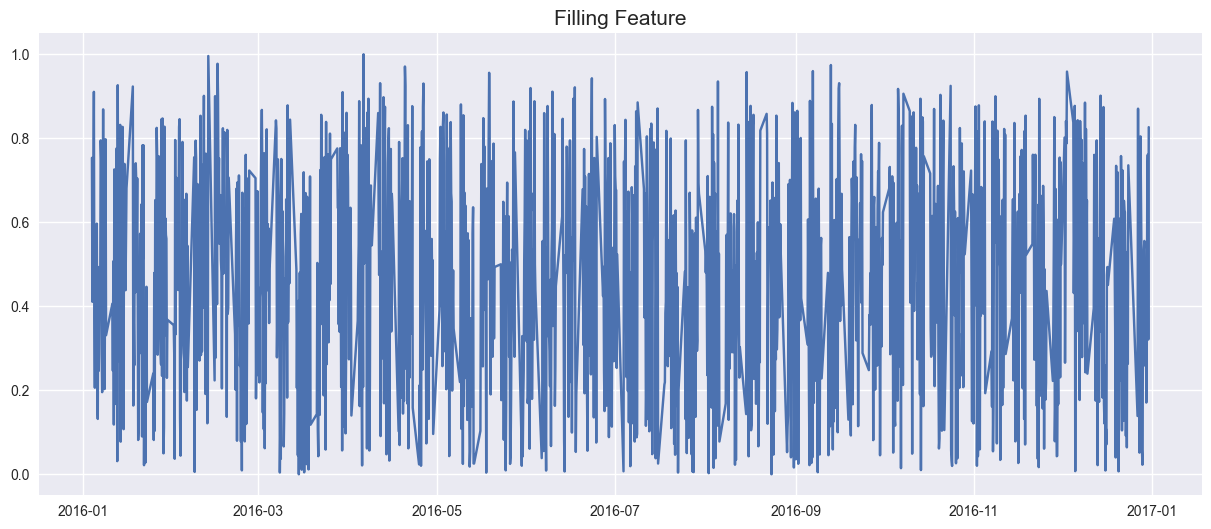

In [4]:
plt.figure(figsize=(15,6))
plt.plot(df["filling"])
plt.title("Filling Feature", size=15)
plt.show()

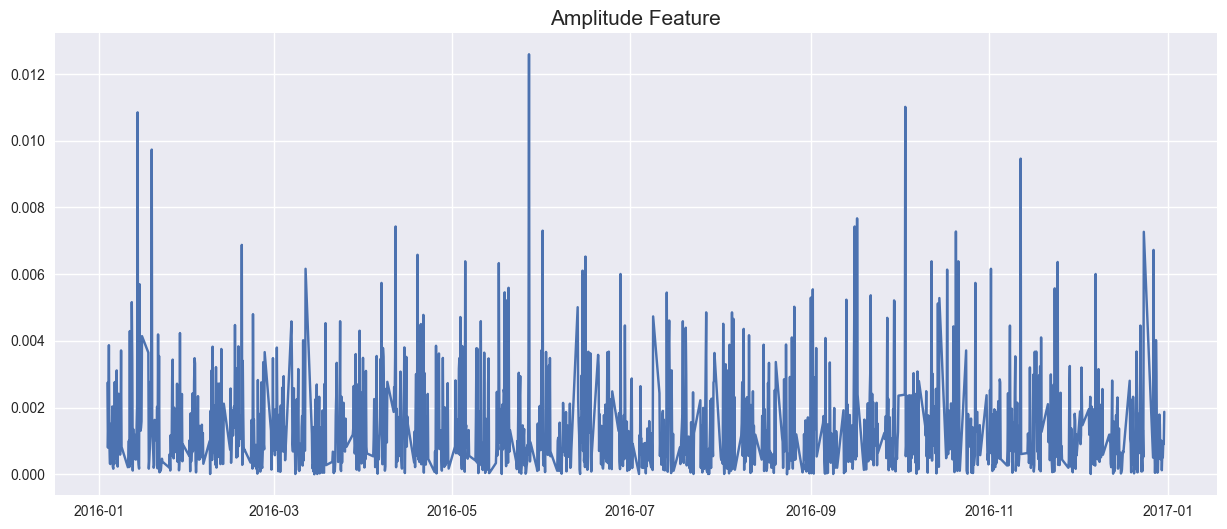

In [5]:
plt.figure(figsize=(15,6))
plt.plot(df["amplitude"])
plt.title("Amplitude Feature", size=15)
plt.show()

<br>

## **Spread Calculation**

The `compute_spread` function provides a simple yet valuable insight into the **difference between the highest and lowest price** within a given period. This metric is useful for analyzing intra-bar market volatility.

  $$ \text{spread} = \text{high} - \text{low} $$

The higher the `spread` value is, the more the market is volatile.


In [6]:
df["spread"] = fe.candle.compute_spread(df=df, high_col="high", low_col="low")

df["spread"]

time
2016-01-04 00:00:00    0.382338
2016-01-04 04:00:00    0.204575
2016-01-04 08:00:00    0.243635
2016-01-04 12:00:00    0.611644
2016-01-04 16:00:00    0.110041
                         ...   
2016-12-30 04:00:00    0.215988
2016-12-30 08:00:00    0.073740
2016-12-30 12:00:00    0.131355
2016-12-30 16:00:00    0.291873
2016-12-30 20:00:00    0.234034
Name: spread, Length: 1548, dtype: float64

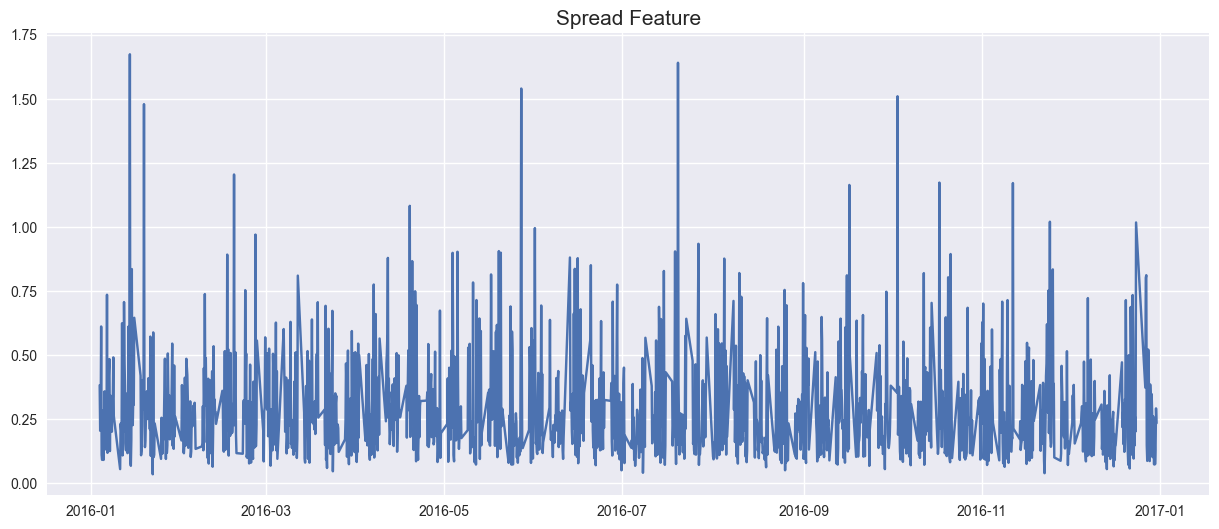

In [7]:
plt.figure(figsize=(15,6))
plt.plot(df["spread"])
plt.title("Spread Feature", size=15)
plt.show()

<br>

## **Price Distribution**

The `price_distribution` function calculates the **percentage of closing prices** that lie within a given **relative range** of their **rolling high-low interval**.

This feature is especially helpful to identify **price compression** (when many prices cluster in the center of the range) or **volatility bursts** (when price spreads out to the extremes).

It works by:
- Computing the **min** and **max** price in each rolling window.
- Evaluating the **number of prices** that fall between two dynamic thresholds:
  - `start_percentage` (e.g., 0.25) of the range
  - `end_percentage` (e.g., 0.75) of the range

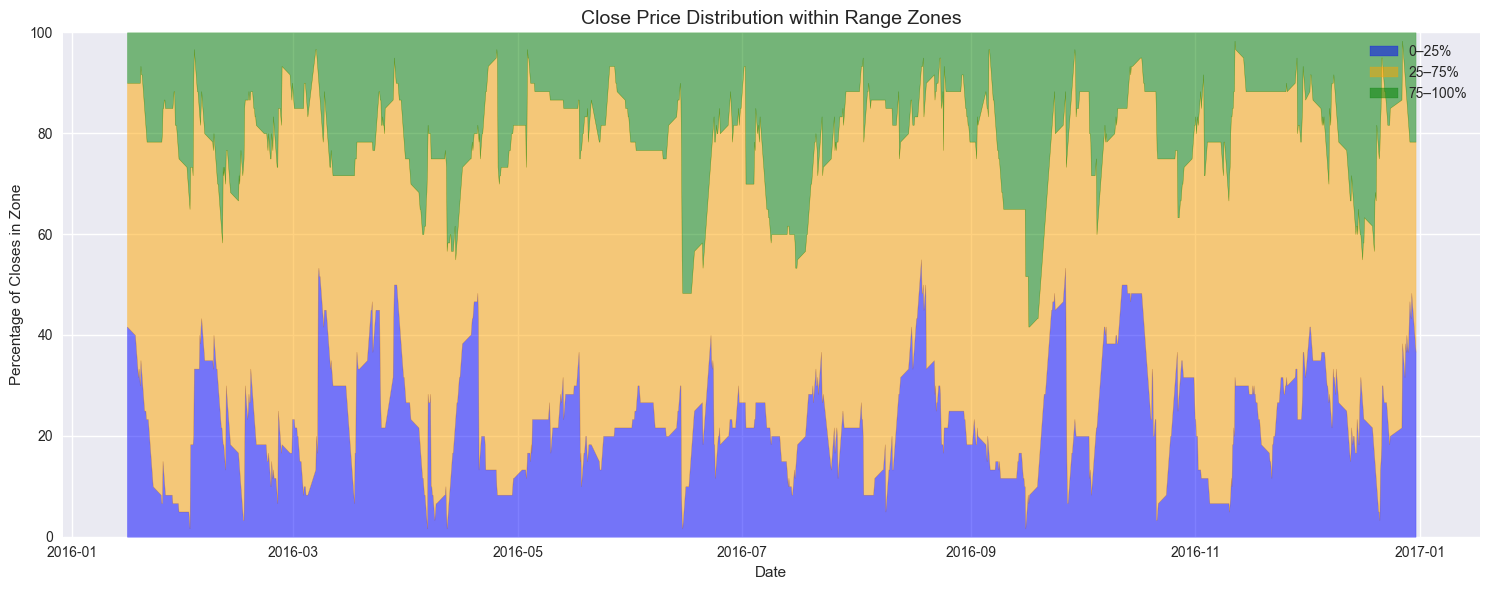

In [13]:
# Compute the percentage of closing prices in different range zones using Quantreo
df["0_to_25"] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.0, end_percentage=0.25)
df["25_to_75"] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.25, end_percentage=0.75)
df["75_to_100"] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.75, end_percentage=1.0)

# Prepare the stacked layers
bottom_25 = df["0_to_25"]
middle = df["25_to_75"]
top = df["75_to_100"]

# Create the stacked area plot
fig, ax = plt.subplots(figsize=(15, 6))

ax.fill_between(df.index, 0, bottom_25, color='blue', alpha=0.5, label='0–25%')
ax.fill_between(df.index, bottom_25, bottom_25 + middle, color='orange', alpha=0.5, label='25–75%')
ax.fill_between(df.index, bottom_25 + middle, bottom_25 + middle + top, color='green', alpha=0.5, label='75–100%')

# Customize the plot
ax.set_ylim(0, 100)
ax.set_title("Close Price Distribution within Range Zones", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Closes in Zone")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()